In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
import researchpy as rp
from scipy import stats
%matplotlib inline
%run 'src/functions.py'

In [13]:
#read csv file into Pandas DataFrame
df = pd.read_csv('data/diabetic_data.csv')

## Introduction
With estimated costs in the order of tens of billions per annum, hospital readmissions impose a significant financial burden on health care institutions across the nation. Up until more recent times, there was not a lot of incentive for Hospitals to reduce these readmissions. When Center for Medicares and Medicaid Services began public reporting hospital readmission rates, the ethical and professional incentive was there, but hospitals that aimed to reduce readmissions were losing revenue unless they could fill their beds. Enter the Hospital Readmissions Reduction Program (HRRP) circa 2013 which provided financial incentive for Hospitals to reduce readmissions. 

This has still proven to be a difficult task but hospitals are employing a number of strategies to reduce the preventable readmissions. Progress has been made since the implementation of the HRRP but estimates of readmissions that could have been prevented are still as high as 70%. It is therefore in their best interest to find ways to further reduce this undesirable outcome. 

## Strategy

- Data Preprocessing
- Exploratory Data Analysis
- Hypothesis Testing

## Data Overview

The data set was made available by the UCI Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

- It contains 101766 observations with 50 different features. 
- Features are largely categorical variables

## Data Preprocessing

The metric of interest that labels whether a patient was readmitted or not has three possible values: 

- **<30** : Patients that were readmitted in less than thirty days. 
- **>30** : Patients that were readmitted in greater than thirty days. 
- **NO** : Patients that were not readmitted

The metric of concern according to the HRRP is patients that were readmitted in less than thirty days. Therefore we will rename the column to 'readmitted_<30d' and combine the '>30' and 'NO'.  

In [14]:
df = df.rename(columns={'readmitted':'readmitted_<30d'})

In [15]:
# finding frequency of patients readmitted in less than 30 days. 
df['readmitted_<30d'].replace({'>30': 'False', 'NO': 'False',
                               '<30': 'True'}, inplace=True)
readmitcounts = pd.DataFrame(df.groupby(df['readmitted_<30d']).size())
readmitcounts = readmitcounts.reset_index()
readmitcounts.columns = ['readmitted_<30d', 'frequency']
readmitcounts


,readmitted_<30d,frequency
0,False,90409
1,True,11357


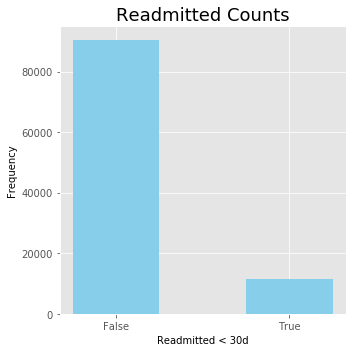

In [46]:
fig,ax = plt.subplots(1, figsize=(5,5))
ax.bar(readmitcounts['readmitted_<30d'], readmitcounts.frequency,
       color='skyblue',width=0.5)
ax.set_ylabel('Frequency',fontsize=10,color='black')
# ax.set_xticks(color='black')
# ax.set_yticks(color='black')
ax.set_xlabel('Readmitted < 30d',fontsize=10,color='black')
ax.set_title('Readmitted Counts',fontsize=18)
plt.tight_layout()
plt.savefig('img/target.png')

Taking a cursory glance at the data showed that a '?' was used where values were unknown. To address this, we will replace all '?' with np.nan. This will paint a more honest picture of any missing values. 


In [17]:
df = df.replace('?',np.nan)

In [18]:
missing_data(df,5)

["Column 'weight' is missing 96.86% of data",
 "Column 'payer_code' is missing 39.56% of data",
 "Column 'medical_specialty' is missing 49.08% of data"]

**What do we do with the columns containing missing data?**

- Since weight is missing ~97% of data, we will drop the column. It would have been a nice feature to evaluate. 
- Additionally, payer_code and medical_specialty are missing ~40 and ~50 % of data respectively. Although there are other ways to deal with this, we will remove the columns. 

In [19]:
df.drop(['weight','payer_code','medical_specialty'], axis=1, inplace=True)


A good next step would be to evaluate all the values that each feature contains. If the feature contains a large amount of values (i.e. Patient ID, encounter ID) we will just take a count of the unique values in the column. 

In [20]:
# iterate through all columns and extract the unique values in each column
for col in df.columns:
    colstr = str(col)
    vals = df[colstr].unique()
    
    if len(vals) < 35:
        print(colstr)
        print(vals)
    else:
        print(colstr +': '+str(len(vals))+' unique values')

encounter_id: 101766 unique values
patient_nbr: 71518 unique values
race
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency
[ 0  1  2  4  3  9  5  7  6  8 22 25 10 13 42 16 11 28 15 14 18 12 21 20
 19 46 76 37 64 63 54 24 29]
number_inpatient
[ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 17 16 21 18 19]
diag_1: 717 unique values
diag_2: 749 unique values
diag_3: 790 unique values
number_diagnoses
[ 1

Since 'examide' and 'citoglipton' only contain one unique value, we will drop these two features from the data frame. 

In [21]:
df.drop(['citoglipton', 'examide'], axis=1, inplace=True)

Another column that needed cleaning was the **discharge_disposition_id** column. This column along with **admission_type_id** and **admission_source_id** all contained numerical values. These numeric values only served as identifiers and didn't actually have any ordered meaning. The id translations were provided in a separate csv file 'IDs_mapping.csv'.  


In [22]:
dfid = pd.read_csv('data/IDs_mapping.csv')

In [23]:
#split up ID mapping data frame into it's respective columns

admission_type = dfid[0:8]
admission_type.set_index('admission_type_id',inplace=True)

dc_dispo = dfid[9:40]
dc_dispo.columns = ['discharge_disposition_id', 'description']
dc_dispo = dc_dispo.drop(index=9)
dc_dispo = dc_dispo.reset_index()
dc_dispo = dc_dispo.drop('index',axis=1)
dc_dispo.set_index('discharge_disposition_id',inplace=True)

admission_source = dfid[41:]
admission_source.columns = ['admission_source_id','description']
admission_source = admission_source.drop(index=41)
admission_source = admission_source.reset_index()
admission_source = admission_source.drop('index',axis=1)
admission_source.set_index('admission_source_id',inplace=True)

Reviewing these ID data frames, there are some values that will need to be removed from the main df. 
After consideration, we will remove records that have a discharge_disposition_id that pertains to a patient that has expired or was discharged and transferred to hospice care--reason being that they shouldn't be counted in the group that wasn't readmitted as this would misrepresent that population. 


Based on these criteria, we will remove records where<br> discharge_disposition_id = 11,13,14,18,19,20,21

In [24]:
df = df[~df.discharge_disposition_id.isin([11,13,14,18,19,20,21])]

In [25]:
print('Removing observations with above discharge_disposition_id \
accounted for a {:2.2f}% loss of data'.format((101766-95652)/101766 
                                              * 100))

Removing observations with above discharge_disposition_id accounted for a 6.01% loss of data


In [26]:
#create a data frame with just the patients readmitted in <30 days. 
readmitmask = df['readmitted_<30d'] == 'True'
readmitsdf = df[readmitmask]


## Exploratory Data Analysis

It is worth exploring if any of the numeric variables have any correlations. We will write a function to exract numeric columns from a data frame of choice and return a numeric data frame. This will be performed for both the 

Extraction of numeric columns and plotting in a pairplot did not yield any strong correlations. 

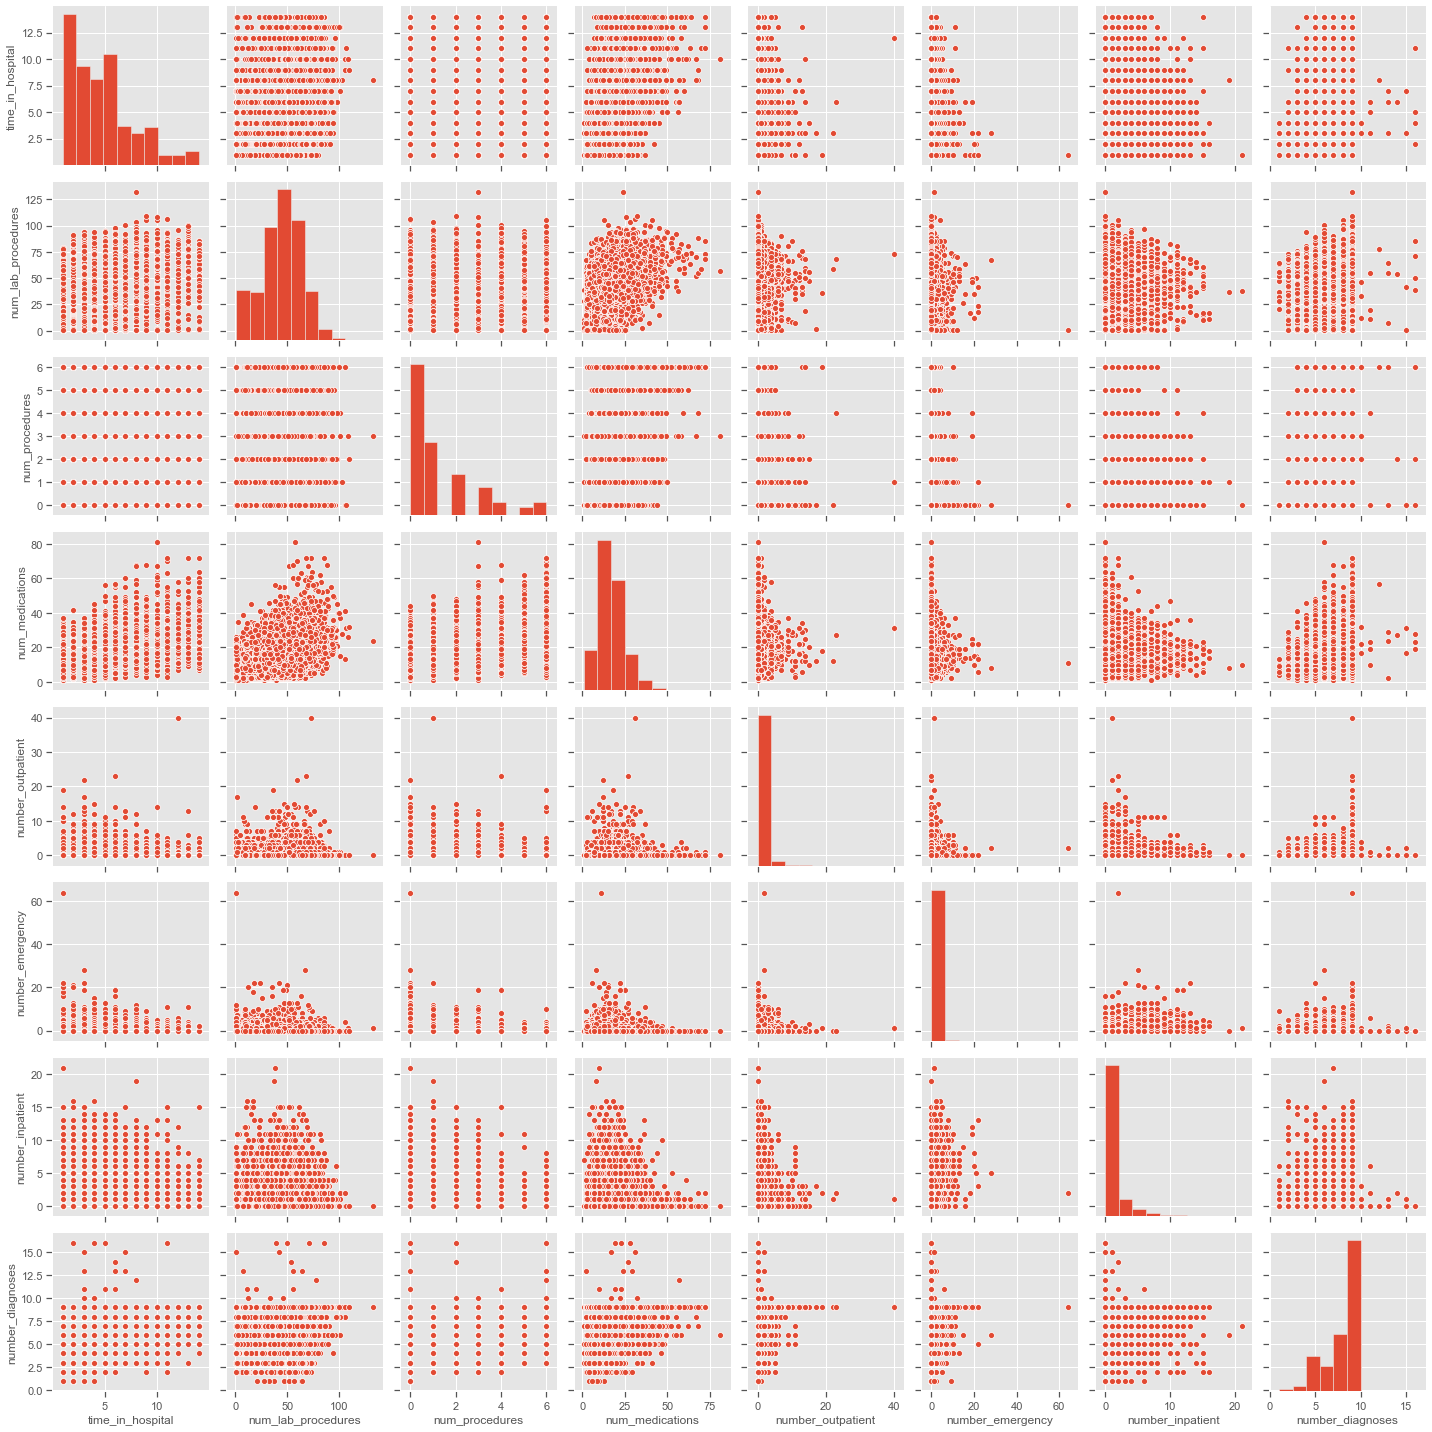

In [48]:
readmitsnumeric = get_num_cols(readmitsdf).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)
sns.pairplot(readmitsnumeric)
plt.tight_layout()


In [35]:
dfnumeric = get_num_cols(df).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)

# sns.pairplot(dfnumeric)
# plt.tight_layout()

The columns with integer values did not provide a lot of insight. These int columns are largely nominal and interval variables which explains their lack of fruitful information in the pairplots generated above. 

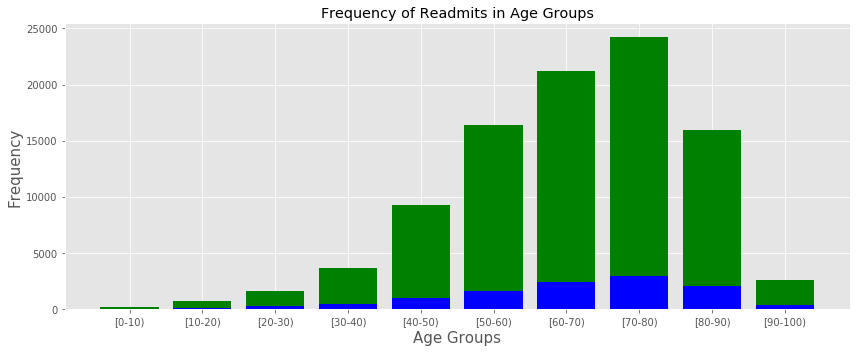

In [37]:
readmitsagedf = pd.DataFrame(readmitsdf.groupby(readmitsdf.age).size())
readmitsagedf = readmitsagedf.reset_index()
readmitsagedf.columns = ['age group', 'freq']

agedf = pd.DataFrame(df.groupby(df.age).size())
agedf = agedf.reset_index()
agedf.columns = ['age group', 'freq']

fig,ax = plt.subplots(1, figsize=(12,5))
ax.set_title('Frequency of Readmits in Age Groups')
ax.bar(agedf['age group'], agedf.freq, color='green')
ax.bar(readmitsagedf['age group'], readmitsagedf.freq, color='blue')
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xlabel('Age Groups', fontsize=15)
ax.set_xticks(range(len(agedf)))
ax.set_xticklabels(agedf['age group'])
plt.tight_layout()
plt.savefig('img/readmitsbyage')

In [ ]:
readmitsa1cdf = pd.DataFrame(readmitsdf.groupby(readmitsdf.A1Cresult).size())
readmitsa1cdf = readmitsa1cdf.reset_index()
readmitsa1cdf.columns = ['A1C groups', 'freq']
readmitsa1cdf.head()
# a1cdf = pd.DataFrame(df.groupby(df.A1Cresult).size())
# a1cdf = a1cdf.reset_index()
# a1cdf.columns = ['A1C groups', 'freq']

# fig,ax = plt.subplots(1, figsize=(12,5))
# ax.set_title('Frequency of Readmits in A1C level Groups')
# ax.bar(a1cdf[~a1cdf['A1C groups'].isin([None])], a1cdf.freq, color='green')
# ax.bar(readmitsa1cdf[~readmitsa1cdf['A1C groups'].isin([None])], readmitsa1cdf.freq, color='blue')
# ax.set_ylabel('Frequency',fontsize=15)
# ax.set_xlabel('A1C Groups', fontsize=15)
# ax.set_xticks(range(len(a1cdf)))
# ax.set_xticklabels(a1cdf['A1C groups'])
# plt.tight_layout()

In [ ]:
readmitsdf.metformin.value_counts()

# EDA TO BE CONTINUED! More analysis required
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>





....

## Hypothesis Testing


Since the columns in this dataset are largely categorical variables, we want to test some of these for indepence. 

As there are various mechanisms of action by which diabetes medication can treat the disease, there are many medications on the market. This can be seen by the 23 various diabetes medications that are included in this data set. Finding the optimal medication for each patient can often be an exercise of trial and error. Adverse side-effects secondary to a medication change often result in hospitalization as patients need to be monitored with serial blood glucose tests. 

I'd like to test the change in medication column and the readmission column for independence. Since these both only contain two possible values, this would be a fairly straight forward X^2 test

#### State Null and Alternative Hypothesis

>$H_0$:Change in Medicine and Readmission are independent variables

>$H_A$:They are not independent

#### Assumptions

- When testing the data, the cells should be counts of cases and not percentages. It is okay to convert to percentages after testing the data
- The levels (groups) of the variables being tested are mutually exclusive
- Each participant contributes to only one cell within the Chi-square table
- The groups being tested must be independent
- The value of expected cells should be greater than 5 for at least 20% of the cells

Credit to [this](https://pythonfordatascience.org/chi-square-test-of-independence-python/) medium article

#### Assemble the Contingency Table

In [ ]:
crosstab = pd.crosstab(df['change'],df['readmitted_<30d'])
crosstab

#### Decide how Suprised You Need to Be to Reject Your Skeptical Assumption

Let's set the rejection threshold pretty stringently: $\alpha = 0.03$.

#### Compute the Test Statistic


The first step in the Chi Squared test is to compute the following test statistic:

$$ T = \sum_i \frac{(O_i - E_i)^2}{E_i} $$

In [ ]:
stats.chi2_contingency(crosstab)

The logic of the Chi Squared test is that this quantity follows a certain distribution, the chi squared distribution.

In [ ]:
degfree = 1
x = np.linspace(0,10, num=250)

fig, ax = plt.subplots(1, figsize=(16,3))

chisq = stats.chi2(degfree)

ax.plot(x, chisq.pdf(x), linewidth=4,
       label = 'Degrees of Freedom = 1')
ax.set_ylim(0,2)
ax.legend()

The 2-way Chi squared test provides the degrees of freedom as:
    
$$ \text{(Number of rows - 1)} * \text{(Number of columns - 1)} $$

The plot above shows the PDF for a Chi-Square distribution with 1 degree of freedom

With a Chi Square test score of 39.02, we can appreciate a very small p-value as the test shows. 

In [ ]:
table, results = rp.crosstab(df['change'],df['readmitted_<30d'],prop='col', test='chi-square')
table

In [ ]:
results

Since we will be repeating this test for several variables, we will write a function

In [ ]:
def get_cat_cols(df):
    '''
    Description: Takes a dataframe as it's input and returns a Pandas
    DataFrame of all columns that contain data of type 'str'
    of all continuous/numeric columns
    Input: Pandas DF
    Output: DF of categorical features
    '''
    intlist=[]
    for col in df.columns:
        colstring = str(col)
        for val in df[colstring]:
            if type(val) == str:
                intlist.append(colstring)
                break
    return pd.DataFrame(df[intlist])
cat_cols = get_cat_cols(df).columns

In [ ]:
for col in cat_cols:
    print(col)

In [ ]:
def chisq(df,cols):
    results = []
    for col in cols:
        crosstab = pd.crosstab(df[col],df['readmitted_<30d'])
        result = stats.chi2_contingency(crosstab)
        results.append('The feature: ' + col + ' had a ChiSquare score of {}, p-value of {} with {} degrees of Freedom'.format(result[0], result[1], result[2]))
    return results

chisq(df, cat_cols )

#### Results

Based on these test results, we can reject the $H_0$ and conclude that hospital readmissions have a very weak dependence on changes in medicine. 

In [ ]:
stats.chi2_contingency(crosstab)[:3]